In [90]:
from eratos.creds import AccessTokenCreds
from eratos.adapter import Adapter
import eratos.climate as eratosClimate
import eratos.helpers as helpers
import os
import yaml
from yaml.loader import SafeLoader
import json
import pprint
import datetime
import shapely
from shapely import wkt, geometry
from datetime import timezone
from keplergl import KeplerGl
import geopandas as gpd
import numpy as np
import datetime
import json
import pandas as pd
import numpy as np
from datetime import  timezone
from datetime import date
import geopandas as gpd
from shapely.geometry import box
from shapely import wkt
import datetime
import os

ERATOS_KEY = os.environ['ERATOS_KEY']
ERATOS_SECRET = os.environ['ERATOS_SECRET']

ecreds = AccessTokenCreds(
  ERATOS_KEY,
  ERATOS_SECRET
)
eadapter = Adapter(ecreds)

In [91]:
def get_forecast_data_for_points(ern: str, point_list):

    # Parse the date range using the iso8601 format
    e_data = eadapter.Resource(ern=ern)
    #access the gridded data via the gridded data adapter:
    gridded_e_data = e_data.data().gapi()
         # Load Point strings as Shapely Points
    wkt_list = []
    for point in (point_list):
        loc_shape = wkt.loads(point)
        if type(loc_shape) is not geometry.Point:
            raise ValueError('value inside point_list should be a WKT point')
        loc= [loc_shape.y, loc_shape.x]
        wkt_list.append(loc)


    data_query_array = gridded_e_data.get_point_slices(gridded_e_data.get_key_variables()[0], 'SPP', pts=wkt_list, starts=[0], ends=[-1],strides =  [1])

    times = []
    for unix_time in gridded_e_data.get_subset_as_array('time'):

        date = datetime.datetime.fromtimestamp(unix_time)

        # Format the datetime object as an ISO 8601 string
        date_8601 = date.isoformat()
        times.append(date_8601)

    return data_query_array,times

point_list = ['POINT(144.968654  -37.817960)']
ern = 'ern:e-pn.io:resource:eratos.blocks.bom.adfd.dailymaxtempforecastau6km'
ern_temp_hourly = 'ern:e-pn.io:resource:eratos.blocks.bom.adfd.hourlytempforecastau6km'
ern_rainfall_3hourly = 'ern:e-pn.io:resource:eratos.blocks.bom.adfd.3hourlymeanprecipforecastau6km'
data_query_array,times = get_forecast_data_for_points(ern_rainfall_3hourly,point_list)

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calplot
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap

In [86]:
?plt.bar

In [88]:
dates = pd.date_range('2022-01-01', '2022-12-31')
# set theme
def rolling_window(a, window):
    """
    gives a 2d array for rolling statistics e.g if a=[a1, a2, a3...], window = 3,
    returns [[a1, a2, a3], [a2, a3, a4], [a3, a4, a5] ...]
    :param a: np.array of numbers
    :param window: window for rolling
    :return:
    """
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


sns.set()
N = 365
x = np.arange(N)
# generate some random data
y = 20 + 5*np.sin(0.25*x) + np.random.normal(0.5, 5, N)
mean = rolling_window(y, 5).mean(axis = -1)
std = rolling_window(y, 5).std(axis = -1)

# plot data
fig, ax = plt.subplots()
ax.plot(dates, mean, 'black', label='5 day average temp')
# fill_between gives the error bands
ax.fill_between(dates, mean - std, mean + std, color='darkorange', alpha=0.2, label = '1std')
ax.fill_between(dates, mean - 2*std, mean + 2*std, color='yellow', alpha=0.2, label = '2std')

ax.hlines(y=[30, 10], xmin = dates[0], xmax = dates[364], linestyle = '--', label = 'thresholds', color = 'black', alpha = 0.5)
ax.set_xlabel('time')
ax.set_ylabel('temp')
ax.legend(title='', loc =(1.04, 0.4))
plt.show()

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))

# put the labels at 45deg since they tend to be too long
fig.autofmt_xdate()

SyntaxError: EOL while scanning string literal (3783415211.py, line 1)

In [89]:
caldata = pd.DataFrame({
    'dates':dates,
    'temp': y,
    'sma_5': mean,
    'std_5':std
})
caldata = caldata.set_index(dates)

In [64]:
def warning_thresholds(sma, std, threshold, type):
    """
    gives a warning based on thereshold temperature and moving average+std bands
    :param sma:
    :param std:
    :param threshold_temp:
    :param type:
    :return:
    """
    result = []
    if type == 'lower':
        lower_1 = sma - std
        lower_2 = sma - 2*std
        for t, l1, l2 in zip(sma, lower_1, lower_2):
            if t < threshold:
                result.append(3)
            elif threshold < t and threshold > l1:
                result.append(2)
            elif threshold < l1 and threshold > l2:
                result.append(1)
            else:
                result.append(0)
    elif type == 'upper':
        upper_1 = sma + std
        upper_2 = sma + 2*std
        for t, u1, u2 in zip(sma, upper_1, upper_2):
            if t > threshold:
                result.append(3)
            elif threshold > t and threshold < u1:
                result.append(2)
            elif threshold > u1 and threshold < u2:
                result.append(1)
            else:
                result.append(0)
    else:
        pass # error message whatveer

    return result

In [65]:
caldata['lower_warning'] = warning_thresholds(caldata.sma_5, caldata.std_5, threshold = 10, type = 'lower')
caldata['upper_warning'] = warning_thresholds(caldata.sma_5, caldata.std_5, threshold = 30, type = 'upper')

In [75]:
caldata.lower_warning

2022-01-01    0
2022-01-02    0
2022-01-03    0
2022-01-04    0
2022-01-05    0
             ..
2022-12-27    0
2022-12-28    0
2022-12-29    0
2022-12-30    0
2022-12-31    0
Freq: D, Name: lower_warning, Length: 365, dtype: int64

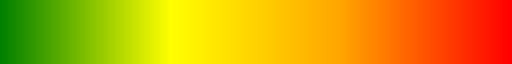

In [77]:
cmap = LinearSegmentedColormap.from_list('custom', [(0, 'green'), (1./3, 'yellow'), (2./3, 'orange'), (1, 'red')])
cmap

(<Figure size 1000x170 with 1 Axes>,
 array([<AxesSubplot:ylabel='2022'>], dtype=object))

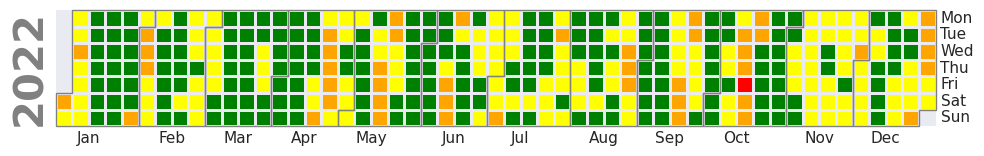

In [85]:
calplot.calplot(caldata.upper_warning + 1, cmap=cmap, colorbar=False)

In [81]:
caldata.upper_warning

2022-01-01    2
2022-01-02    1
2022-01-03    1
2022-01-04    1
2022-01-05    2
             ..
2022-12-27    2
2022-12-28    2
2022-12-29    2
2022-12-30    1
2022-12-31    1
Freq: D, Name: upper_warning, Length: 365, dtype: int64

In [45]:
caldata

,dates,temp,sma_5,std_5,lower_warning,upper_warning
2022-01-01,2022-01-01,27.389801,26.394623,3.704049,green,orange
2022-01-02,2022-01-02,27.308259,26.296670,3.671978,green,orange
2022-01-03,2022-01-03,30.184608,28.475107,1.396119,green,orange
2022-01-04,2022-01-04,19.292423,26.296670,3.671978,green,orange
2022-01-05,2022-01-05,27.798022,26.394623,3.704049,green,orange
...,...,...,...,...,...,...
2022-12-27,2022-12-27,22.378283,26.362469,4.645927,green,orange
2022-12-28,2022-12-28,30.270819,26.596687,4.804820,green,orange
2022-12-29,2022-12-29,25.633576,26.016372,4.709938,green,orange
2022-12-30,2022-12-30,20.748368,23.725907,3.852077,green,orange


In [34]:
caldata.iloc[1]

dates    2022-01-02 00:00:00
temp               20.689651
sma_5              22.455484
std_5                4.42265
Name: 2022-01-02 00:00:00, dtype: object

In [5]:
data_query_array

array([[0.75      , 1.41999817, 1.30000305, 0.44000244, 0.25      ,
        0.11000061, 0.18000793, 0.13999939, 0.21000671, 0.25      ,
        0.24000549, 0.13000488, 0.0900116 , 0.07000732, 0.12001038,
        0.12001038, 0.04000854, 0.0900116 , 0.0900116 , 0.04000854,
        0.04000854, 0.02000427, 0.02000427, 0.05000305, 0.01000977,
        0.01000977, 0.01000977, 0.01000977, 0.01000977, 0.01000977,
        0.01000977, 0.01000977, 0.01000977, 0.01000977, 0.01000977,
        0.01000977, 0.01000977, 0.01000977, 0.01000977, 0.01000977,
        0.        , 0.        , 0.        , 0.        , 0.01000977,
        0.01000977, 0.01000977, 0.01000977, 0.01000977, 0.01000977,
        0.01000977, 0.01000977, 0.01000977, 0.01000977, 0.01000977,
        0.01000977]])

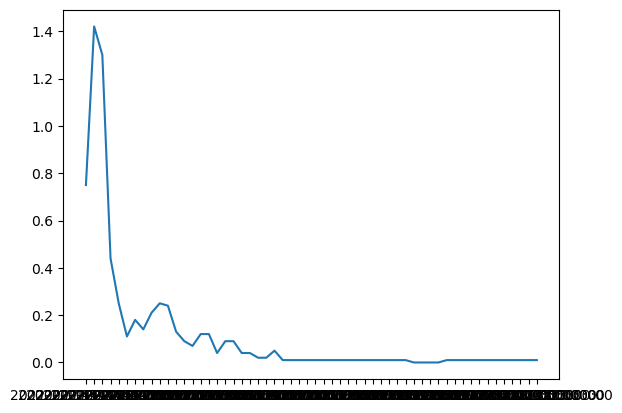

In [9]:
plt.plot(times,data_query_array.reshape(-1,1))

In [8]:
data = pd.DataFrame({'rainfall' : data_query_array.flatten(), 'times' : times})
data.times = pd.to_datetime(data.times)
data = data.set_index('times')

In [9]:
?calplot.calplot

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 1250x170 with 2 Axes>,
 array([<AxesSubplot:ylabel='2022'>], dtype=object))

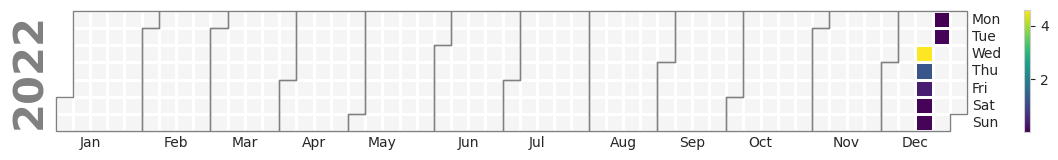

In [11]:
calplot.calplot(data['rainfall'])

In [18]:
sns.set_theme()

In [22]:
data.times = pd.to_datetime(data.times)

In [33]:
data.times

0    2022-12-14 02:00:00
1    2022-12-14 05:00:00
2    2022-12-14 08:00:00
3    2022-12-14 11:00:00
4    2022-12-14 14:00:00
5    2022-12-14 17:00:00
6    2022-12-14 20:00:00
7    2022-12-14 23:00:00
8    2022-12-15 02:00:00
9    2022-12-15 05:00:00
10   2022-12-15 08:00:00
11   2022-12-15 11:00:00
12   2022-12-15 14:00:00
13   2022-12-15 17:00:00
14   2022-12-15 20:00:00
15   2022-12-15 23:00:00
16   2022-12-16 02:00:00
17   2022-12-16 05:00:00
18   2022-12-16 08:00:00
19   2022-12-16 11:00:00
20   2022-12-16 14:00:00
21   2022-12-16 17:00:00
22   2022-12-16 20:00:00
23   2022-12-16 23:00:00
24   2022-12-17 02:00:00
25   2022-12-17 05:00:00
26   2022-12-17 08:00:00
27   2022-12-17 11:00:00
28   2022-12-17 14:00:00
29   2022-12-17 17:00:00
30   2022-12-17 20:00:00
31   2022-12-17 23:00:00
32   2022-12-18 02:00:00
33   2022-12-18 05:00:00
34   2022-12-18 08:00:00
35   2022-12-18 11:00:00
36   2022-12-18 14:00:00
37   2022-12-18 17:00:00
38   2022-12-18 20:00:00
39   2022-12-18 23:00:00


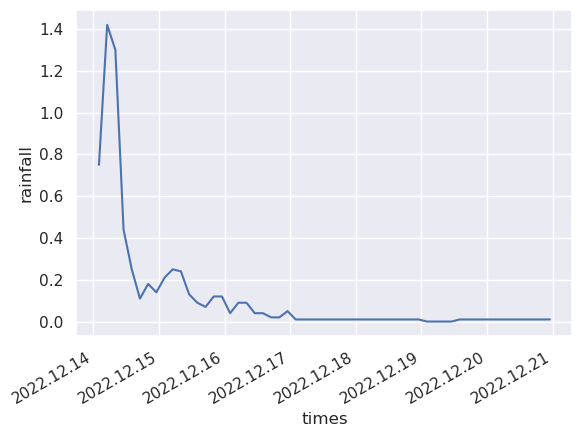

In [38]:
fig, ax = plt.subplots()
sns.lineplot(data, x = 'times', y = 'rainfall')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))

# put the labels at 45deg since they tend to be too long
fig.autofmt_xdate()